<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_2_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
#@title INSTALLS
!pip install livelossplot --quiet

In [74]:
#@title IMPORTS
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import tqdm.notebook as nb
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import CelebA as DS  #other options CIFAR10, STL10
from torchvision import datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, SubsetRandomSampler
from IPython.display import clear_output
from livelossplot import PlotLosses

In [59]:
#@title IMAGE HELPERS
def imshow(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):
  x = x.clamp(0, 1)
  return x
  
def show_image(img):
  img = to_img(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, x, y):
  with torch.no_grad():  
    images = images.cpu()
    images = to_img(images)
    np_imagegrid = make_grid(images, x, y).numpy()
    figure(figsize=(20,20))
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

In [148]:
#@title HYPERPARAMETERS
image_size = 128
channels=3
batch_size = 128
latent_dim=100
lr = .002
b1=.5
b2=0.999
epochs=100
sample_interval=100
latent_dim=100

In [31]:
#@title SETUP DATA FOLDERS
dataset_name = "celeba" 
dataset_url = 'https://www.dropbox.com/s/kgqofw91l8m1mk6/celeba.zip?dl=1'
img_root_folder = 'data'
os.makedirs(img_root_folder, exist_ok=True)
image_folder = img_root_folder + "/%s" % dataset_name 
print(f"Image data folders constructed {image_folder}")
os.makedirs(image_folder, exist_ok=True)

Image data folders constructed data/celeba


In [32]:
#@title DOWNLOAD IMAGES
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = dataset_url
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:        
        zfile.extractall(img_root_folder)
        print(f"Downloaded & Extracted {zipurl}")

Downloaded & Extracted https://www.dropbox.com/s/kgqofw91l8m1mk6/celeba.zip?dl=1


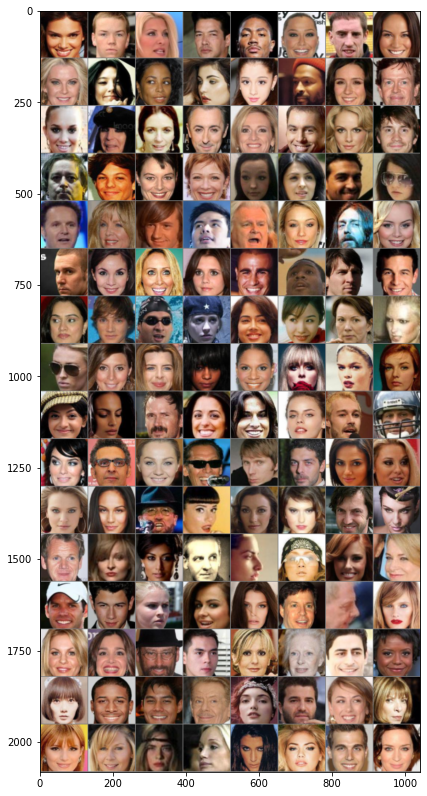

In [149]:
#@title LOAD IMAGES
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size*.7),
                               transforms.Resize(image_size),                               
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

train_dataset = datasets.ImageFolder('./data/', transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(make_grid(images),14)

In [150]:
#@title GENERATOR MODEL
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.init_size = image_size // 4
    self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

    self.conv_blocks = nn.Sequential(
      nn.BatchNorm2d(128),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 128, 3, stride=1, padding=1),
      nn.BatchNorm2d(128, 0.8),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, 3, stride=1, padding=1),
      nn.BatchNorm2d(64, 0.8),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv2d(64, channels, 3, stride=1, padding=1),
      nn.Tanh(),
    )

  def forward(self, z):
    out = self.l1(z)
    out = out.view(out.shape[0], 128, self.init_size, self.init_size)
    img = self.conv_blocks(out)
    return img

In [151]:
#@title DISCRIMINATOR MODEL
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    def discriminator_block(in_filters, out_filters, bn=True):
      block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), 
                nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
      if bn:
          block.append(nn.BatchNorm2d(out_filters, 0.8 ))
      return block

    self.model = nn.Sequential(
      *discriminator_block(channels, 16, bn=False),
      *discriminator_block(16, 32),
      *discriminator_block(32, 64),
      *discriminator_block(64, 128),
    )

    # The height and width of downsampled image
    ds_size = image_size // 2 ** 4
    self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

  def forward(self, img):
    out = self.model(img)
    out = out.view(out.shape[0], -1)
    validity = self.adv_layer(out)

    return validity

In [152]:
#@title MODELS, OPTIMIZERS and LOSS FUNCTION
def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(m.bias.data, 0.0)

loss_fn = torch.nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

cuda = True if torch.cuda.is_available() else False

if cuda:
  generator.cuda()
  discriminator.cuda()
  loss_fn.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [153]:
#@title OPTIMIZERS AND TENSOR SETUP
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

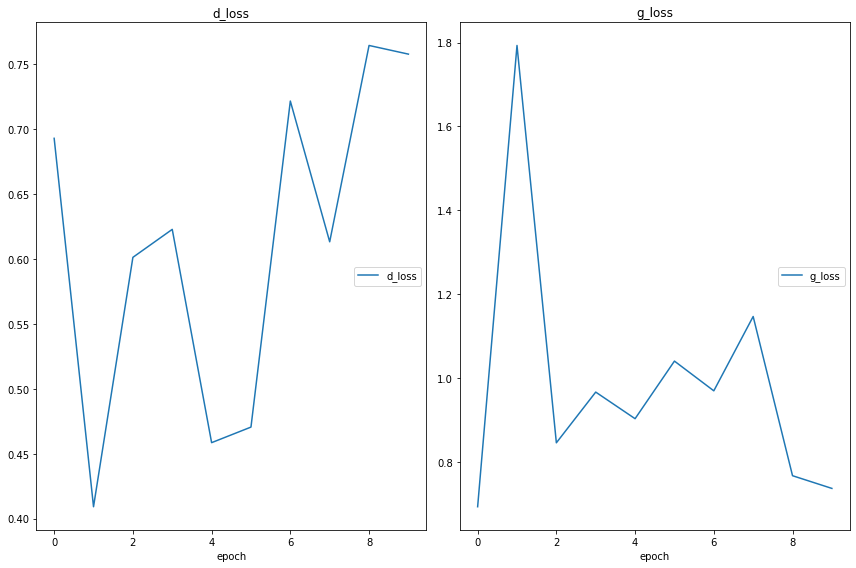

d_loss
	d_loss           	 (min:    0.409, max:    0.765, cur:    0.758)
g_loss
	g_loss           	 (min:    0.693, max:    1.793, cur:    0.737)


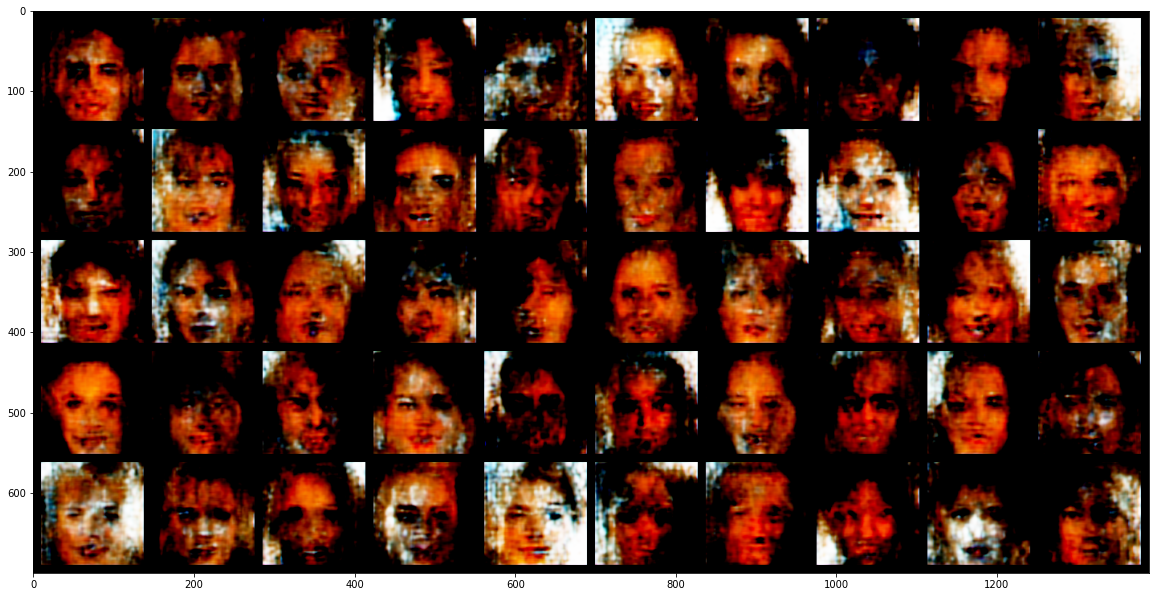

In [ ]:
#@title TRAINING
liveloss = PlotLosses()
history={ }
for epoch in range(epochs):
  for i, (imgs, _) in enumerate(train_loader):

      # Adversarial ground truths
      valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
      fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

      # Configure input
      real_imgs = Variable(imgs.type(Tensor))

      # -----------------
      #  Train Generator
      # -----------------

      optimizer_G.zero_grad()

      # Sample noise as generator input
      z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

      # Generate a batch of images
      gen_imgs = generator(z)

      # Loss measures generator's ability to fool the discriminator
      g_loss = loss_fn(discriminator(gen_imgs), valid)

      g_loss.backward()
      optimizer_G.step()

      # ---------------------
      #  Train Discriminator
      # ---------------------

      optimizer_D.zero_grad()

      # Measure discriminator's ability to classify real from generated samples
      real_loss = loss_fn(discriminator(real_imgs), valid)
      fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake)
      d_loss = (real_loss + fake_loss) / 2

      d_loss.backward()
      optimizer_D.step()
      history['d_loss'] = d_loss.item()
      history['g_loss'] = g_loss.item()    

      batches_done = epoch * len(train_loader) + i
      if batches_done % sample_interval == 0:        
        liveloss.update(history)
        liveloss.send()
        visualise_output(gen_imgs.data[:50],10, 10)          

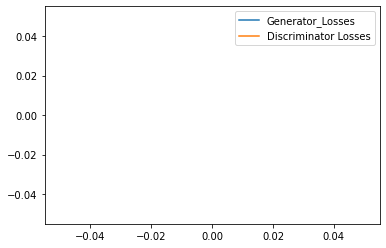

In [70]:
plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.legend()
plt.show()